In [32]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from basis_expansions import NaturalCubicSpline
from dftransformers import (ColumnSelector, Identity,
                            FeatureUnion, MapFeature,
                            Intercept)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
concrete = pd.read_excel('Concrete_Data.xls')

In [3]:
concrete.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
column_names_raw = concrete.columns
print(column_names_raw)

Index([u'Cement (component 1)(kg in a m^3 mixture)',
       u'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       u'Fly Ash (component 3)(kg in a m^3 mixture)',
       u'Water  (component 4)(kg in a m^3 mixture)',
       u'Superplasticizer (component 5)(kg in a m^3 mixture)',
       u'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       u'Fine Aggregate (component 7)(kg in a m^3 mixture)', u'Age (day)',
       u'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')


In [5]:
column_names = [
    'cement',
    'blast_furnace_slag',
    'fly_ash',
    'water',
    'superplasticizer',
    'coarse_aggregate',
    'finite_aggregate',
    'age',
    'compressive_strength',
]
concrete.columns = column_names

In [6]:
concrete.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,finite_aggregate,age,compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


## EDA

/Users/matthewdrury/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


ValueError: too many values to unpack

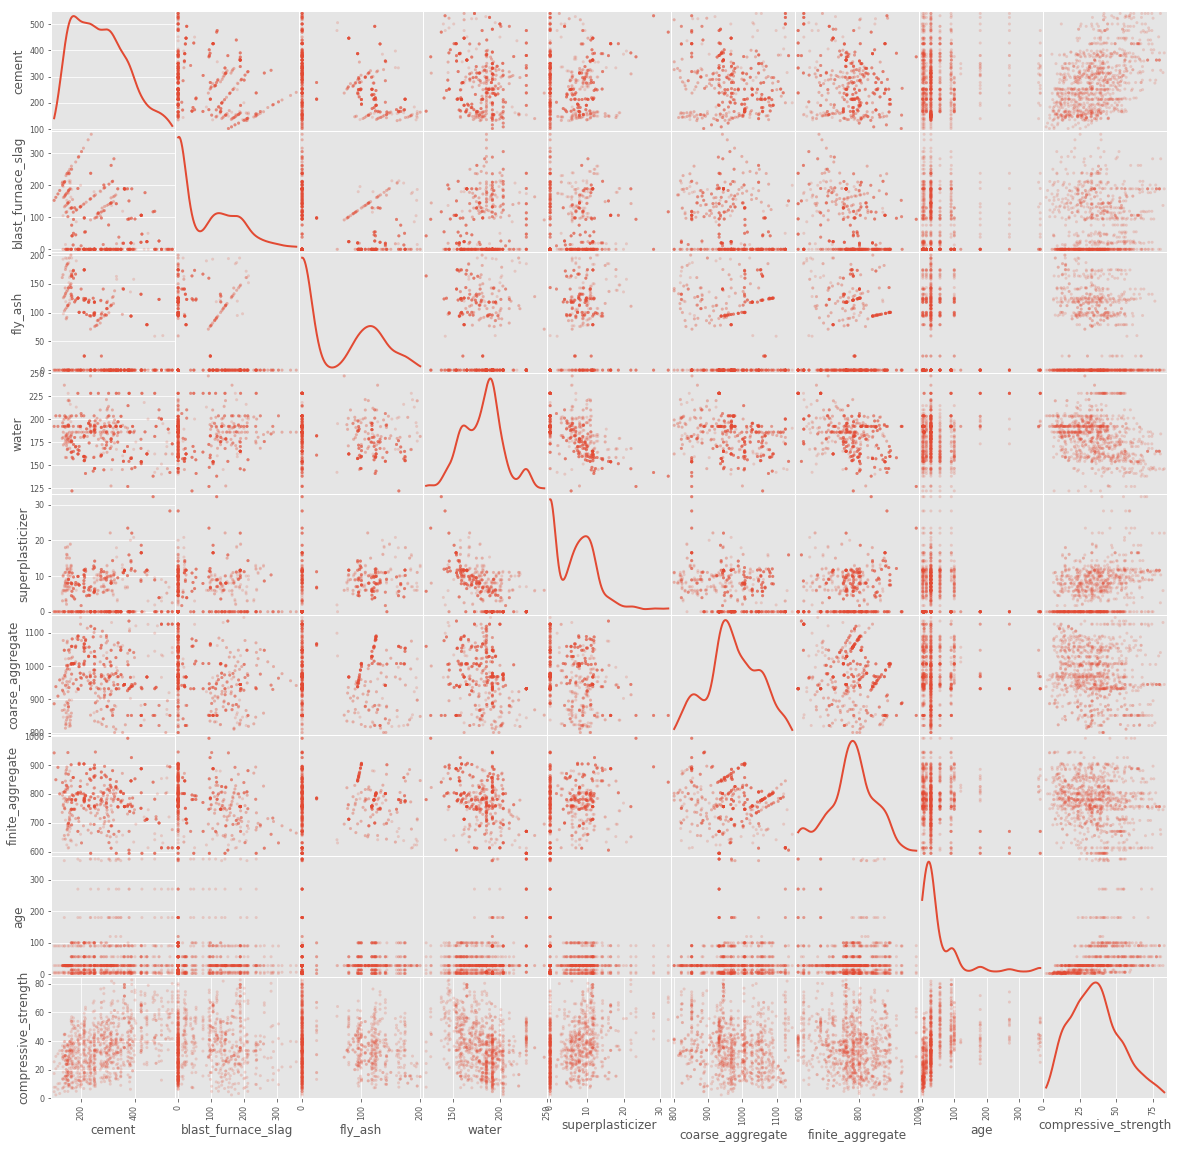

In [36]:
fig, axs = scatter_matrix(concrete, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [7]:
def make_natural_cubic_regression(n_knots):
    return Pipeline([
        ('standardizer', StandardScaler()),
        ('nat_cubic', NaturalCubicSpline(-2, 2, n_knots=n_knots)),
        ('regression', LinearRegression(fit_intercept=True))
    ])

In [8]:
def plot_univariate_smooth(ax, x, y, x_lim=None, mask=None, smooth=True, n_knots=6, bootstrap=False):

    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    if mask is not None:
        if isinstance(mask, pd.Series):
            mask = mask.values
        x = x[mask]
        y = y[mask]
    if not x_lim:
        x_lim = (np.min(x), np.max(x))
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    
    ax.scatter(x, y, color='grey', alpha=0.25)
    if smooth:
        if bootstrap:
            for _ in range(bootstrap):
                x_boot, y_boot = resample(x, y)
                plot_smoother(ax, x_boot, y_boot, 
                              x_lim, n_knots, 
                              alpha=0.5, color="lightblue")        
        plot_smoother(ax, x, y, x_lim, n_knots, 
                      linewidth=3, color="blue")
        
def plot_smoother(ax, x, y, x_lim, n_knots, **kwargs):
    ncr = make_natural_cubic_regression(n_knots)
    ncr.fit(x, y)
    t = np.linspace(x_lim[0], x_lim[1], num=250)
    y_smoothed = ncr.predict(t.reshape(-1, 1))
    ax.plot(t, y_smoothed, **kwargs)

/Users/matthewdrury/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


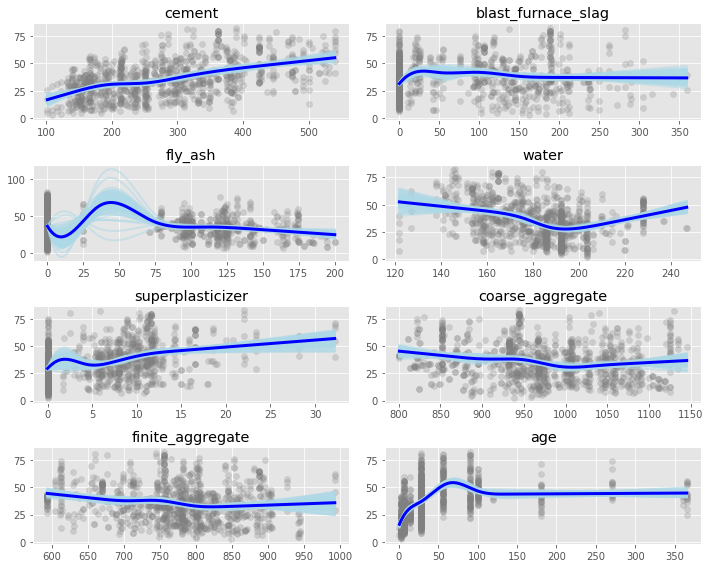

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))
univariate_plot_names = concrete.columns[:-1]

for name, ax in zip(univariate_plot_names, axs.flatten()):
    plot_univariate_smooth(ax, 
                           concrete[name].values.reshape(-1, 1),
                           concrete['compressive_strength'],
                           bootstrap=100)
    ax.set_title(name)
fig.tight_layout()

## How Will We Treat These Varaibles in Regression

Let's look through each of these plots for evidence on how to treat these features in a regression model.

### Cement

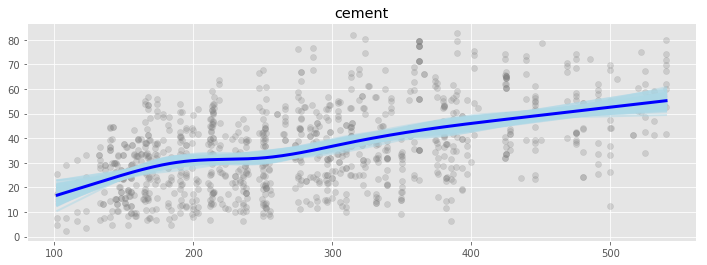

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['cement'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title("cement")

There is not much evidence that fitting anything other than a line is justified, so lets go with the simplest possible fit.

In [11]:
cement_fit = Pipeline([
    ('cement', ColumnSelector(name='cement')),
    ('cement_spline', NaturalCubicSpline(knots=[200, 300, 400]))
])

### Blast Furnace Slag

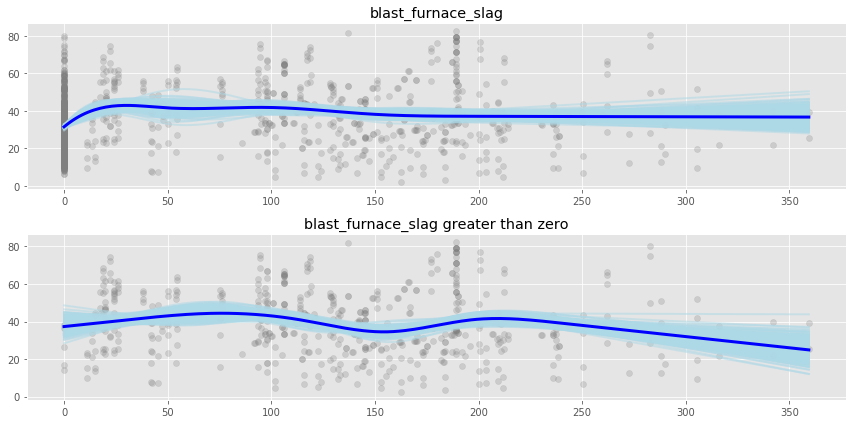

In [12]:
fig, axs = plt.subplots(2, figsize=(12, 6))
plot_univariate_smooth(
    axs[0],
    concrete['blast_furnace_slag'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
axs[0].set_title("blast_furnace_slag")

plot_univariate_smooth(
    axs[1],
    concrete['blast_furnace_slag'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    mask=(concrete['blast_furnace_slag'] > 0),
    bootstrap=200)
axs[1].set_title("blast_furnace_slag greater than zero")
fig.tight_layout()

There is a lot of data with value zero, and this seems to be associated with a lower value of `y` than would otherwise be expected.  

The rest of the data does not tell a straightforward story.  There *may* be a trend, but there may not.  In doublt, let's give the model some flexibility, which we can walk back leter if we end up not needing it.

Taking this into account, we will fit this feature using an indicator varaible, and a spline to :

  - An indicator varaible for `blast_furnace_slag == 0`.
  - A spline for the overall trend of `blast_furnace_slag`.
  
This also brings up an interesting **inferential** question that we may want to study in the future: is the effect of `blast_furnace_slag` non-zero?

In [13]:
slag_fit = Pipeline([
    ('slag', ColumnSelector(name='blast_furnace_slag')),
    ('slag_features', FeatureUnion([
        ('zero_slag', MapFeature(lambda slag: slag == 0.0, 'zero_slag')),
        ('slag_spline', NaturalCubicSpline(knots=[35, 60, 150, 200, 250]) )  
    ]))
])

### Fly Ash

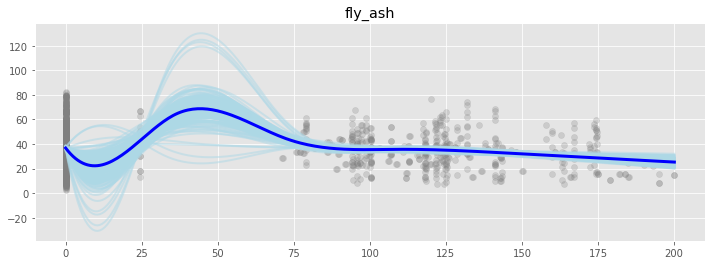

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['fly_ash'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title("fly_ash")

Another similar case to the `blast_furnace_slag`, there is a stong cluster of records with a value of zero.  

There is not much evidence for anything more complicated than linear variation in the large cluster of data to the right of the plot (in the `>= 75` reigon).

The small cluster at `25` seems innocent, but the are *high leverage* points.  If we leave them unattended to, they may exhibit a large effect on the slope of the regression line we hope to fit to the rest of the data.  For this reason, we will also add an indicator varaible for `fly_ash == 25.0`.

In [15]:
fly_ash_fit = Pipeline([
    ('fly_ash', ColumnSelector(name='fly_ash')),
    ('fly_ash_features', FeatureUnion([
        ('zero_fly_ash', MapFeature(lambda ash: ash == 0.0, 'zero_fly_ash')),
        ('twenty_five_fly_ash', MapFeature(
            lambda ash: (ash >= 24.0) & (ash <= 26.0), 'twenty_five_fly_ash')),
        ('fly_ash', Identity())  
    ]))
])

### Water

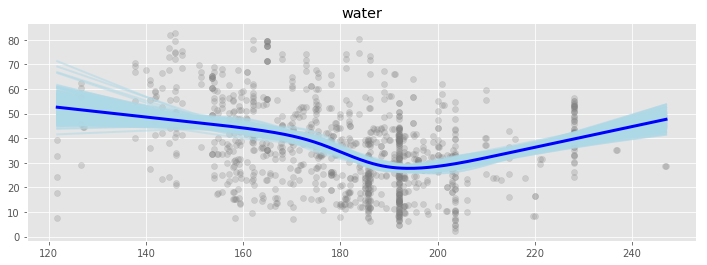

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_univariate_smooth(
    ax,
    concrete['water'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
ax.set_title('water')

Water is an interesting feature.  It looks like too little water harms the compressive strength of a concrete, as does too mych water, with a perfect level somewhere in the middle.  It looks like the engeneers *know* this, as evidenced by the large accumulation of points at around `190`, which is very close to the sweet spot.

We would like to capture this trend, which requires three degrees of freedom, and hence three knots (you can convince yourself of this by playing with the smoothers app.

In [17]:
water_fit = Pipeline([
    ('water', ColumnSelector(name='water')),
    ('water_spline', NaturalCubicSpline(knots=[170, 190, 210]))
])

### Superplasticizer

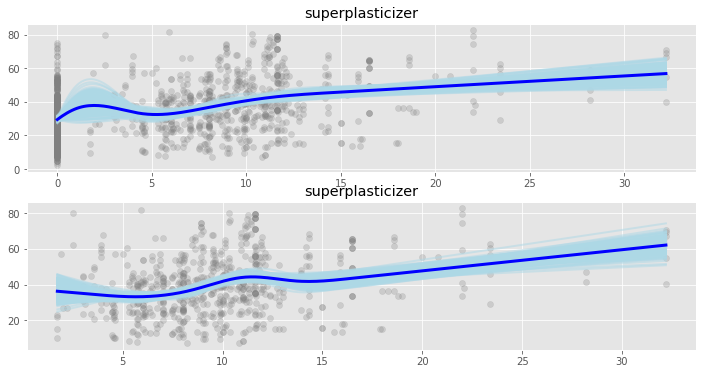

In [18]:
fig, axs = plt.subplots(2, figsize=(12, 6))

plot_univariate_smooth(
    axs[0],
    concrete['superplasticizer'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    bootstrap=200)
axs[0].set_title('superplasticizer')

plot_univariate_smooth(
    axs[1],
    concrete['superplasticizer'].values.reshape(-1, 1), 
    concrete['compressive_strength'],
    mask=(concrete['superplasticizer'] > 0),
    bootstrap=200)
axs[1].set_title('superplasticizer')

Here, again, we need an indicator varaible for the many records which assume that value zero.

For the non-zero records, it looks like there may be some non-linearity in the trend, flatter ...

### A Possible Issue

### Constructing All the Features

In [19]:
feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('cement_fit', cement_fit),
    ('slag_fit', slag_fit),
    ('fly_ash_fit', fly_ash_fit),
    ('water_fit', water_fit)
])

In [20]:
feature_pipeline.fit(concrete)
features = feature_pipeline.transform(concrete)

In [21]:
features.head()

,intercept,cement_spline_linear,cement_spline_0,zero_slag,blast_furnace_slag_spline_linear,blast_furnace_slag_spline_0,blast_furnace_slag_spline_1,blast_furnace_slag_spline_2,zero_fly_ash,twenty_five_fly_ash,fly_ash,water_spline_linear,water_spline_0
0,1.0,540.0,72000.000000,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,162.0,0.0
1,1.0,540.0,72000.000000,1.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,162.0,0.0
2,1.0,332.5,11287.734375,0.0,142.5,5778.125000,2955.345395,0.0,1.0,0.0,0.0,228.0,2280.0
3,1.0,332.5,11287.734375,0.0,142.5,5778.125000,2955.345395,0.0,1.0,0.0,0.0,228.0,2280.0
4,1.0,198.6,0.000000,0.0,132.4,4297.722902,1997.386442,0.0,1.0,0.0,0.0,192.0,265.8


### Fit a Regression and Look at the Coefficients

In [22]:
model = LinearRegression(fit_intercept=False)
model.fit(features.values, y=concrete['compressive_strength'], )

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [23]:
def display_coef(model, coef_names):
    print("{:<35}{:<20}".format("Name", "Parameter Estimate"))
    print("-"*(35 + 20))
    for coef, name in zip(model.coef_, coef_names):
        row = "{:<35}{:<20}".format(name, coef)
        print(row)

In [24]:
display_coef(model, features.columns)

Name                               Parameter Estimate  
-------------------------------------------------------
intercept                          40.3816011804       
cement_spline_linear               0.135576373553      
cement_spline_0                    -0.000157530782402  
zero_slag                          7.86681569179       
blast_furnace_slag_spline_linear   0.248729189007      
blast_furnace_slag_spline_0        -0.00789870622818   
blast_furnace_slag_spline_1        0.010271290673      
blast_furnace_slag_spline_2        -0.00456342574422   
zero_fly_ash                       -4.8026248544       
twenty_five_fly_ash                6.06330861342       
fly_ash                            0.0397283981407     
water_spline_linear                -0.312876950181     
water_spline_0                     0.0067592474795     


### Bootstrap to Get a Feel for How the Coefficients Vary

In [25]:
def bootstrap_train(model, X, y, bootstraps=1000, **kwargs):
    bootstrap_coefs = np.empty(shape=(bootstraps, X.shape[1]))
    for i in range(bootstraps):
        boot_idxs = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_boot = X[boot_idxs, :]
        y_boot = y[boot_idxs]
        M = model(**kwargs)
        M.fit(X_boot, y_boot)
        bootstrap_coefs[i, :] = M.coef_
    return bootstrap_coefs

In [26]:
bootstrap_coefs = bootstrap_train(
    LinearRegression, features.values, concrete['compressive_strength'],
    fit_intercept=False
)

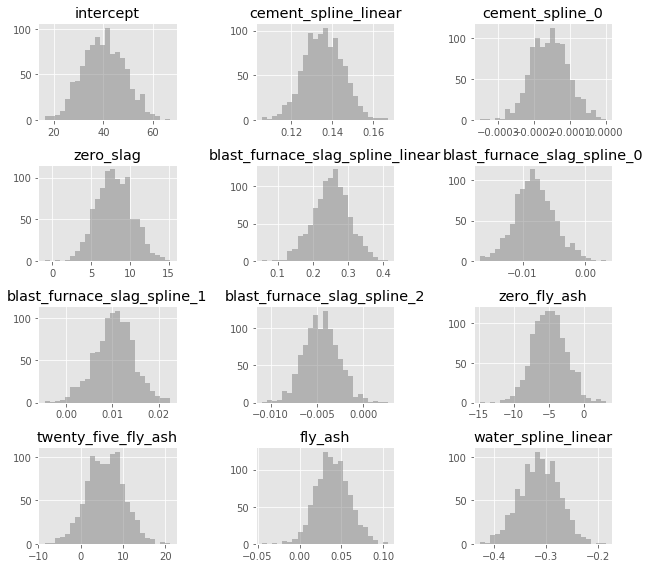

In [27]:
def plot_bootstrap_coefs(bootstrap_coefs, coef_names, n_col=3):
    n_coeffs = bootstrap_coefs.shape[1]
    n_row = int(ceil(n_coeffs / n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*2))
    for idx, ax in enumerate(axs.flatten()):
        ax.hist(bootstrap_coefs[:, idx], bins=25, color="grey", alpha=0.5)
        ax.set_title(coef_names[idx])
    return fig, axs

fig, axs = plot_bootstrap_coefs(bootstrap_coefs, features.columns)
fig.tight_layout()

### Patial Dependence Plots for the Fit Effect of a Predictor

In [28]:
def make_partial_dependence_data(X, var_name,
                                 n_points=250,
                                 pipeline=None):
    Xpd = np.empty((n_points, X.shape[1]))
    Xpd = pd.DataFrame(Xpd, columns=X.columns)
    all_other_var_names = set(X.columns) - {var_name}
    for name in all_other_var_names:
        Xpd[name] = X[name].mean()
    min, max = np.min(X[var_name]), np.max(X[var_name])
    Xpd[var_name] = np.linspace(min, max, num=n_points)
    return Xpd

def plot_partial_depenence(ax, model, X, var_name,
                           y=None, pipeline=None, n_points=250):
    Xpd = make_partial_dependence_data(
        X, var_name, n_points, pipeline=pipeline)
    x_plot = Xpd[var_name]
    if pipeline is not None:
        Xpd = pipeline.transform(Xpd)
    if y is not None:
        ax.scatter(X[var_name], y, color="grey", alpha=0.5)
    y_hat = model.predict(Xpd)
    ax.plot(x_plot, y_hat, linewidth=3, color="blue")

In [29]:
def plot_partial_dependences(model, X, var_names, 
                            y=None, pipeline=None, n_points=250):
    fig, axs = plt.subplots(len(var_names), figsize=(12, 4*len(var_names)))
    for ax, name in zip(axs, var_names):
        plot_partial_depenence(ax, model, X=X, var_name=name, y=y,
                               pipeline=pipeline)
        ax.set_title("{} Partial Dependence".format(name))
    return fig, axs

(<matplotlib.figure.Figure at 0x11f39ac50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x11efd8d50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1200aca10>], dtype=object))

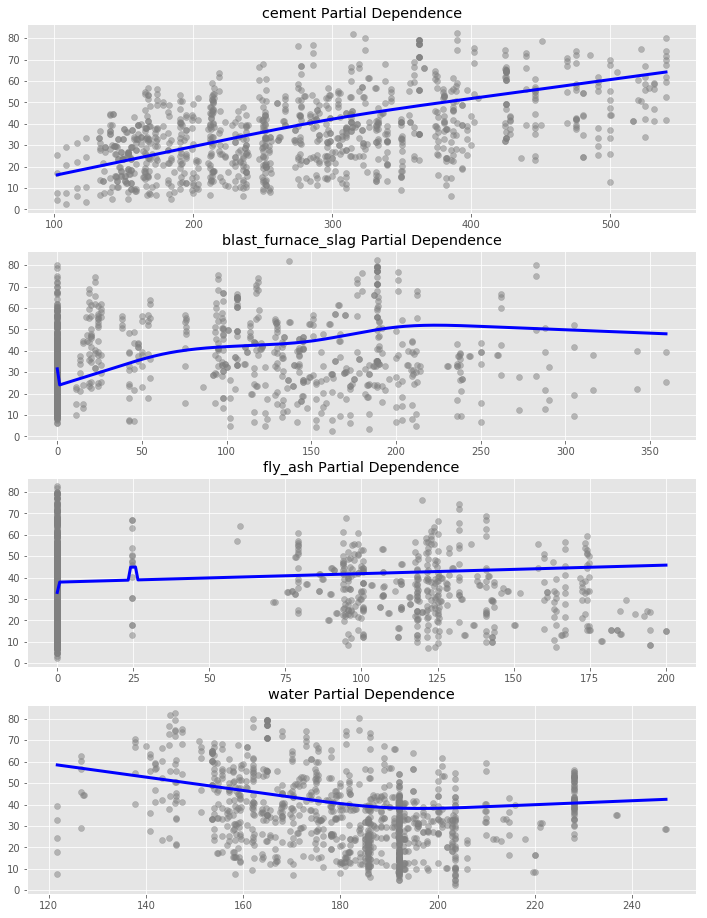

In [30]:
var_names = ["cement", "blast_furnace_slag", "fly_ash", "water"]
plot_partial_dependences(model, 
                         X=concrete,
                         var_names=var_names,
                         pipeline=feature_pipeline,
                         y=concrete["compressive_strength"])